# Convolutional Variational Auto-Encoder example

In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

import numpy as np
import jax
import jax.numpy as jnp

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import crayflow as flow
from craynn import *

SEED = 1110002223

rng = jax.random.PRNGKey(SEED)

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## Data

In [2]:
dataflow = flow.dataflow(
    mnist_paths=flow.instances.mnist.download_mnist('MNIST'),
    mnist=flow.instances.mnist.read_mnist,
)

data_train, labels_train, data_test, labels_test = \
    dataflow['mnist']['data_train', 'labels_train', 'data_test', 'labels_test']()

In [3]:
data_train, labels_train, data_val, labels_val = flow.data.split(0.95, seed=SEED + 1)(data_train, labels_train)

X_train, y_train = jnp.array(data_train, dtype=jnp.float32), jnp.array(labels_train, dtype=jnp.float32)
X_val, y_val = jnp.array(data_val, dtype=jnp.float32), jnp.array(labels_val, dtype=jnp.float32)
X_test, y_test = jnp.array(data_test, dtype=jnp.float32), jnp.array(labels_test, dtype=jnp.float32)

dataset_train = array_dataset(X_train, y_train)
dataset_val = array_dataset(X_val, y_val)
dataset_test = array_dataset(X_test, y_test)

## Network definition

In [4]:
encoder = network((None, 1, 28, 28))(
    conv(32), dropout(0.1), conv(48), dropout(0.1), conv_pool(),
    conv(64), dropout(0.1), conv(96), dropout(0.1), conv_pool(),
    conv(128), dropout(0.1), conv_pool(),
    
    flatten(),
    [dense(96, activation=linear()), dense(96, activation=softplus())]
)

decoder = network((None, 96))(
    dense(128),
    
    reshape((None, 128, 1, 1)),
    deconv_upscale(), dropout(0.1), deconv(96),
    
    deconv_upscale(), dropout(0.1), deconv(64), dropout(0.1), deconv(48),
    deconv_upscale(), dropout(0.1), deconv(32), dropout(0.1), deconv(1),
)

In [5]:
viz.draw_to_notebook(encoder)

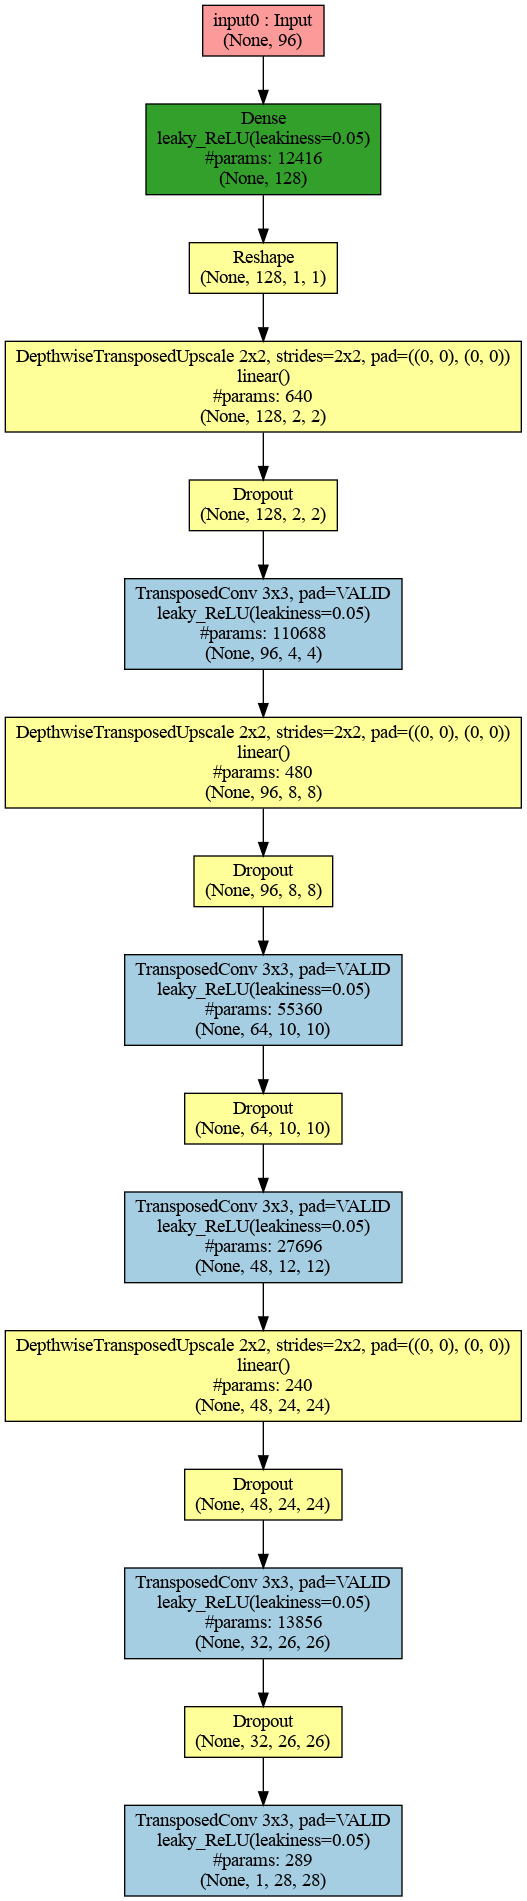

In [6]:
viz.draw_to_notebook(decoder)

## Parameter initialization and normalization

In [9]:
key_encoder, key_decoder, rng = jax.random.split(rng, num=3)
initial_params_encoder = train.initialize_parameters(key_encoder, encoder)
initial_params_decoder = train.initialize_parameters(key_decoder, decoder)


key_encoder, key_decoder, rng = jax.random.split(rng, num=3)
initial_params_encoder = encoder.normalize(key_encoder, X_train[:32], initial_params_encoder, progress=tqdm)
initial_params_decoder = decoder.normalize(
    key_decoder, jax.random.normal(key_decoder, shape=(32, 96)), initial_params_decoder, progress=tqdm
)

normalization:   0%|          | 0/17 [00:00<?, ?it/s]

normalization:   0%|          | 0/16 [00:00<?, ?it/s]

## Training

In [10]:
from crayopt import laprop, iterate

optimizer = laprop(learning_rate=2e-4, )

batch_size = 32

def loss(params, X_batch, rng):
    key_encoder, key_decoder, key_latent = jax.random.split(rng, num=3)
    
    params_enc, params_dec = params

    latent_mean, latent_raw_sigma  = encoder(X_batch, params_enc, rng=key_encoder)
    latent_sigma = jax.nn.softplus(latent_raw_sigma)

    eps = jax.random.normal(key_latent, shape=latent_mean.shape, dtype=latent_mean.dtype)
    latent = latent_mean + latent_sigma * eps
    
    X_reco = decoder(latent, params_dec, rng=key_decoder)
    
    return jnp.mean(
        objectives.elbo(
            X_batch,
            X_reco,
            latent_mean,
            latent_sigma,
            sigma_reconstructed=0.1
        )
    )

@jax.jit
def step(rng, params, state, X, y):
    rng, key_sampling, key_net = jax.random.split(rng, num=3)
    
    indx = jax.random.randint(key_sampling, minval=0, maxval=X.shape[0], shape=(batch_size, ))
    X_batch = X[indx]
    
    l, grad = jax.value_and_grad(loss, argnums=0)(params, X_batch, key_net)
    params_updated, state_updated = optimizer(params, grad, state)
    return rng, params_updated, state_updated, l

In [11]:
n_epoches = 32
n_iterations = X_train.shape[0] // batch_size

initial_params = (initial_params_encoder, initial_params_decoder)

_, (params_encoder, params_decoder), _, losses = iterate(
    lambda rng, params, state: step(rng, params, state, X_train, y_train),
    n_epoches, n_iterations, progress=tqdm
)(
    rng, initial_params, optimizer.initial_state(initial_params)
)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1781 [00:00<?, ?it/s]

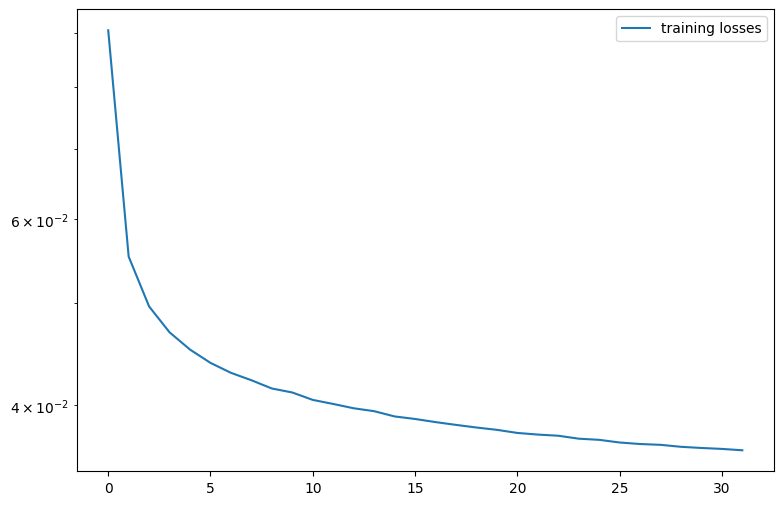

In [12]:
plt.figure(figsize=(9, 6))

plt.plot(np.mean(losses, axis=1), color=plt.cm.tab10(0), label='training losses')

plt.yscale('log')
plt.legend()
plt.show()

## Test

In [13]:
reconstruction_train, = dataset_train.eval(
    lambda x, _: decoder(encoder(x, params_encoder)[0], params_decoder),
    batch_size=128, jit=True
)
reconstruction_test, = dataset_test.eval(
    lambda x, _: decoder(encoder(x, params_encoder)[0], params_decoder),
    batch_size=128, jit=True
)

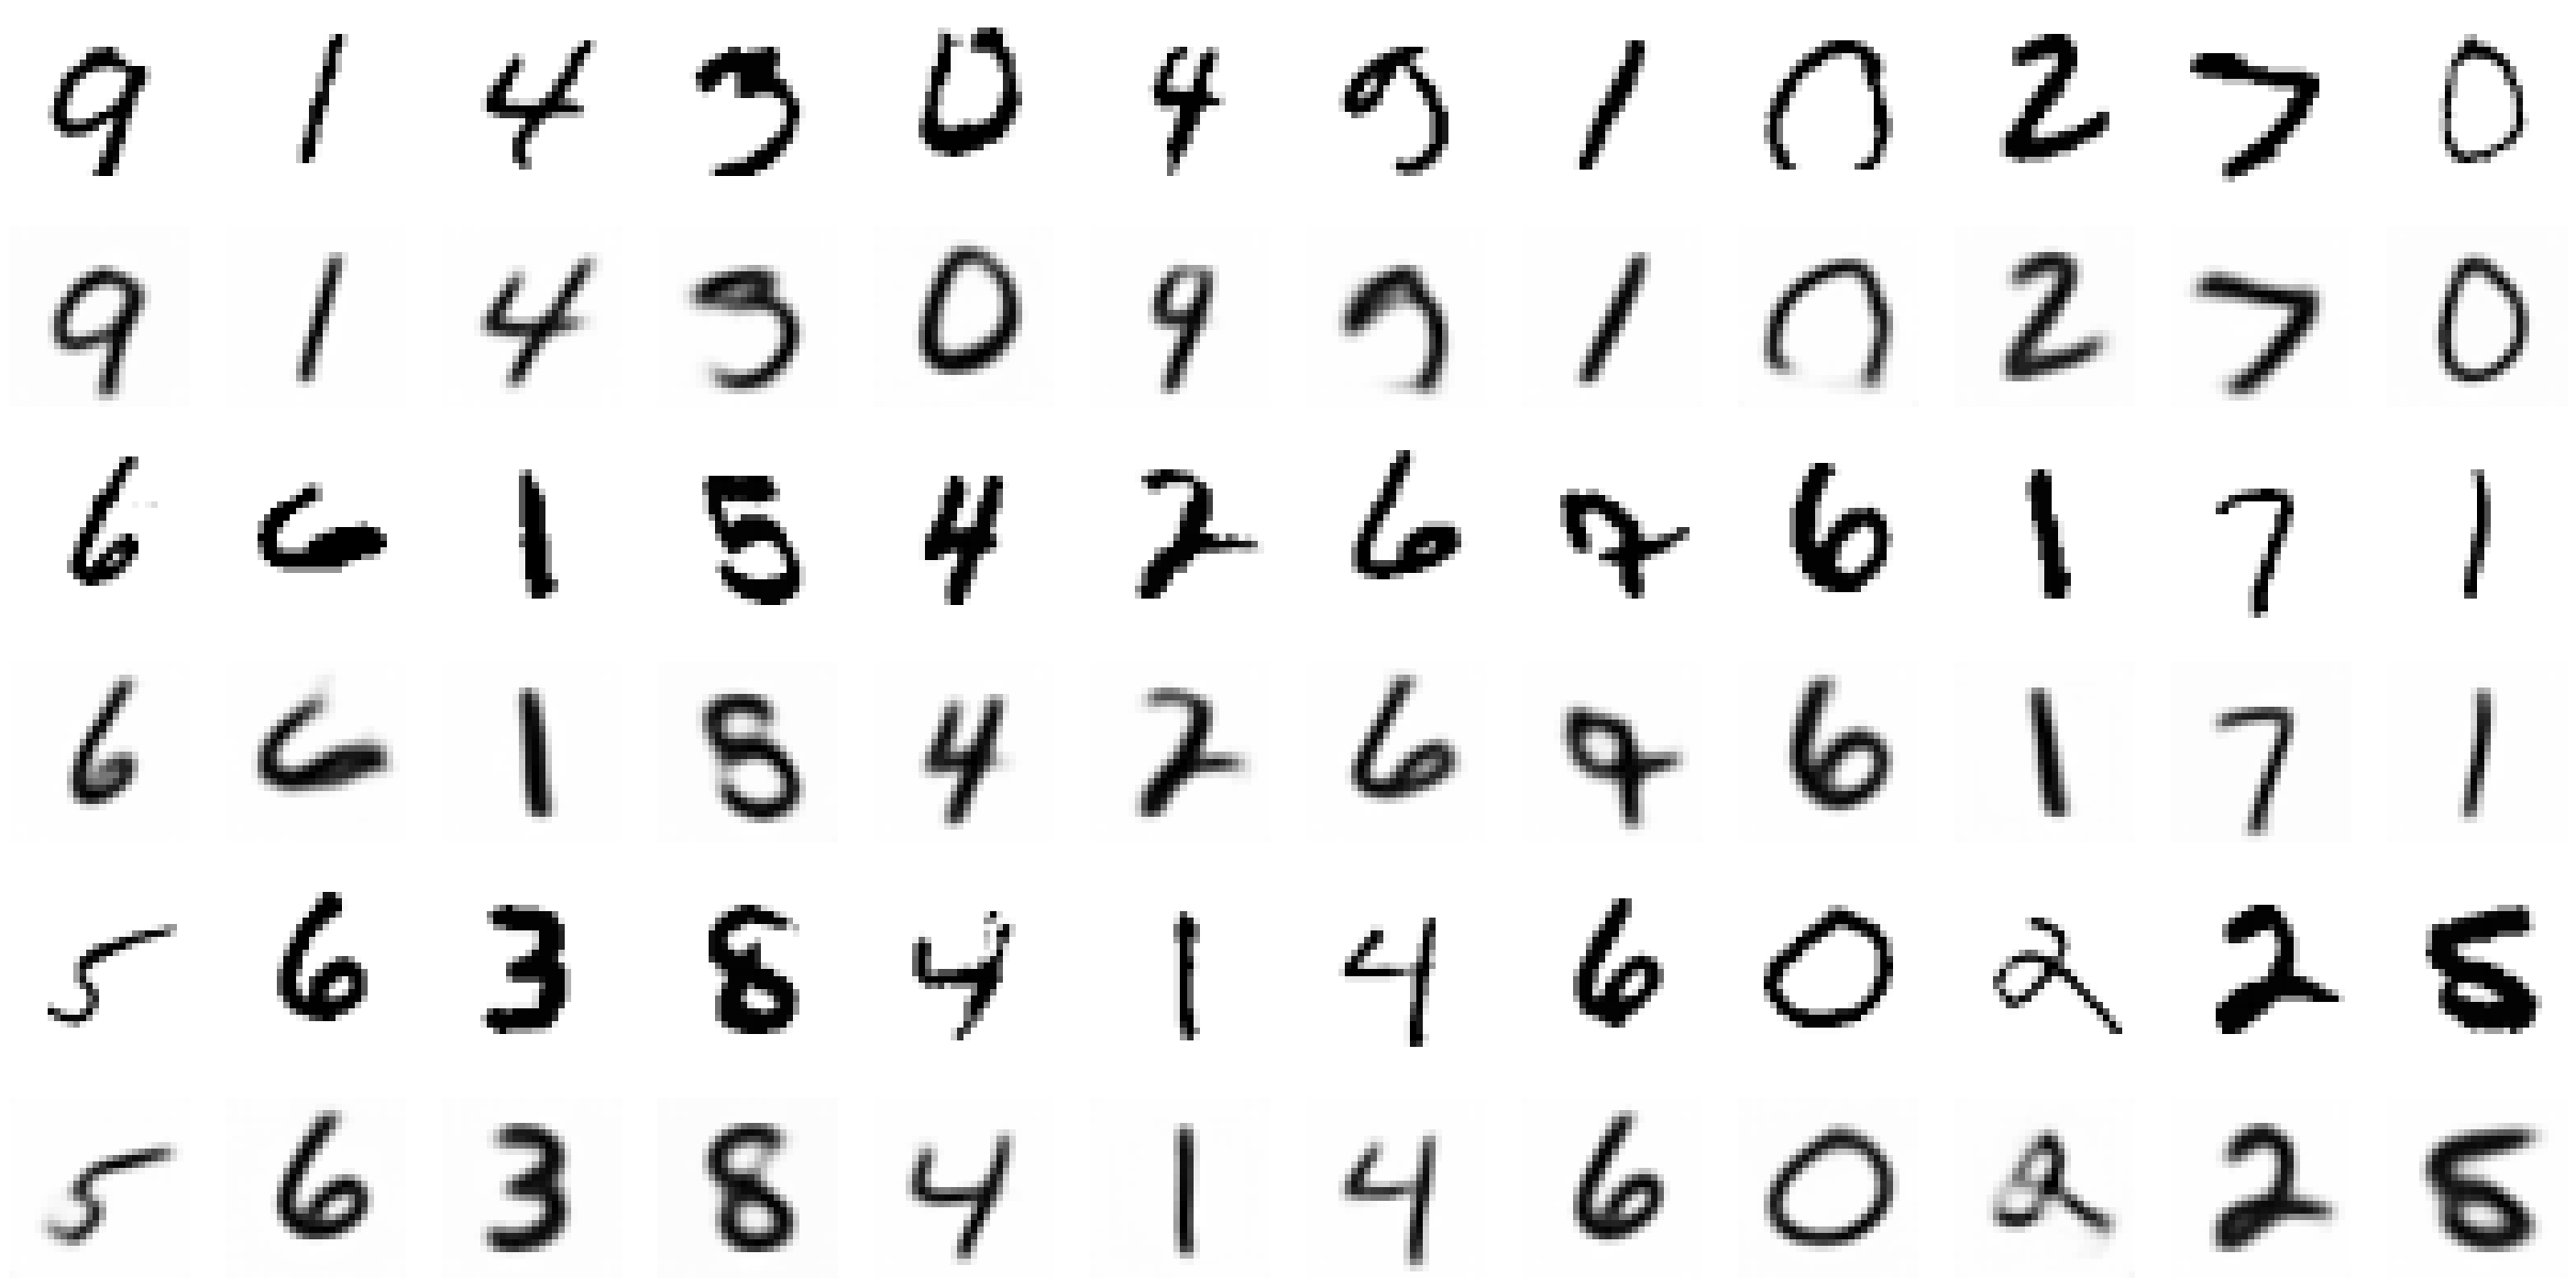

In [14]:
ncols = 12
nrows = 3

indx = jax.random.randint(rng, minval=0, maxval=X_test.shape[0], shape=(ncols * nrows, ))

fig = plt.figure(figsize=(3 * ncols, 3 * 2 * nrows))
axes = fig.subplots(2 * nrows, ncols)

for i in range(nrows):
    for j in range(ncols):
        k = i * ncols + j
        axes[2 * i, j].imshow(X_test[indx[k], 0], cmap=plt.cm.Greys)
        axes[2 * i, j].axis('off')
        
        axes[2 * i + 1, j].imshow(reconstruction_test[indx[k], 0], cmap=plt.cm.Greys)
        axes[2 * i + 1, j].axis('off')

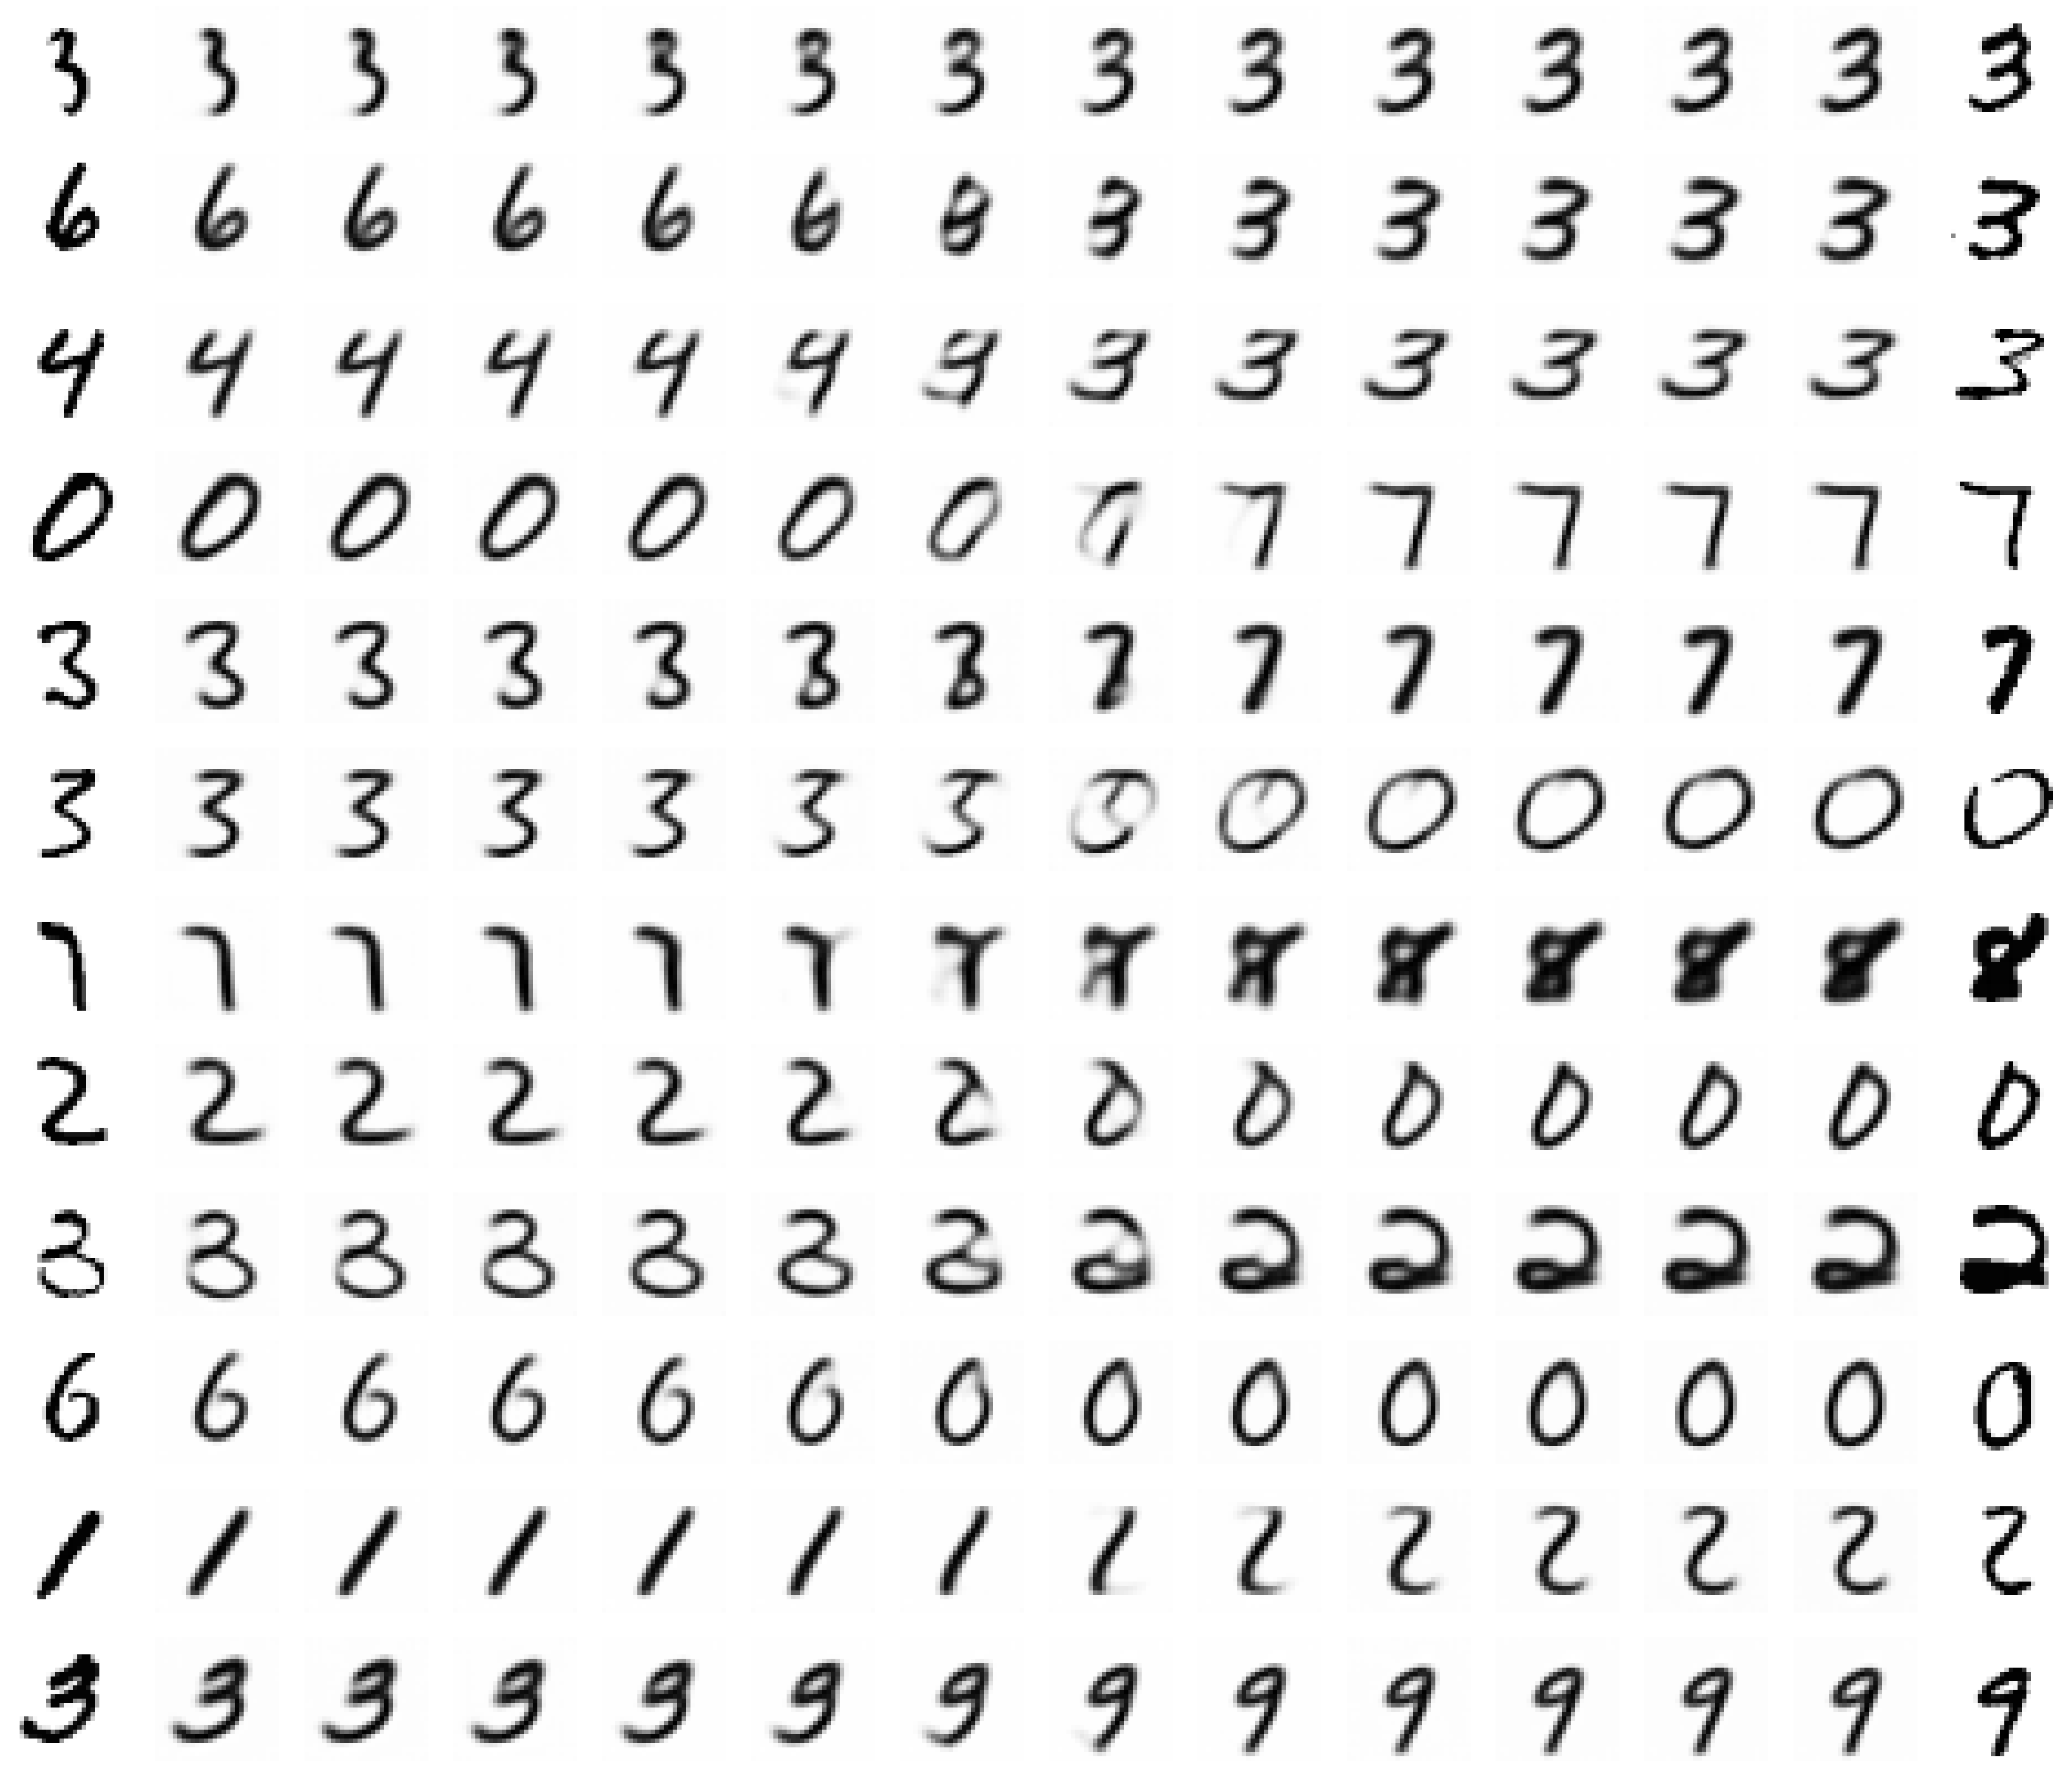

In [15]:
ncols = 12
nrows = 12

indx = jax.random.randint(rng, minval=0, maxval=X_test.shape[0], shape=(nrows, 2))
alphas = jnp.linspace(0, 1, num=ncols)

latent, _ = encoder(X_test[indx].reshape((-1, *X_test.shape[1:])), params_encoder)
latent = latent.reshape((nrows, 2, *latent.shape[1:]))
codes_interpolated = latent[:, 0, None, :] * (1 - alphas[None, :, None]) + \
                     latent[:, 1, None, :] * alphas[None, :, None]

X_reco = decoder(
    codes_interpolated.reshape((-1, codes_interpolated.shape[-1])),
    params_decoder
).reshape((nrows, ncols, 1, 28, 28))

fig = plt.figure(figsize=(3 * (ncols + 2), 3 * nrows))
axes = fig.subplots(nrows, ncols + 2)

for i in range(nrows):
    axes[i, 0].imshow(X_test[indx[i, 0], 0], cmap=plt.cm.Greys)
    axes[i, 0].axis('off')
    
    axes[i, -1].imshow(X_test[indx[i, 1], 0], cmap=plt.cm.Greys)
    axes[i, -1].axis('off')
    
    for j in range(ncols):
        axes[i, j + 1].imshow(X_reco[i, j, 0], cmap=plt.cm.Greys)
        axes[i, j + 1].axis('off')